<a href="https://colab.research.google.com/github/Harshuu000/HTML-CSS-and-Javascript-for-Web-Developers/blob/main/Ramaswamyreddy_Harshavardhan_26061376_AT1_X_notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Pathfinding on Grids — A* (Manhattan) vs Dijkstra
_Generated on 2025-09-03 10:08_


## Objective
Compare **A\*** (with Manhattan heuristic) vs **Dijkstra** on a 2‑D grid with obstacles.

**Setup**
- 4-connected movement (up, down, left, right)
- Unit step cost (1 per move)
- Obstacles generated randomly with a fixed probability
- Start at top-left `(0, 0)`, Goal at bottom-right `(n-1, m-1)`

**Metrics**
- Path cost (steps)
- Nodes expanded
- Runtime (seconds)
- Success rate across multiple random seeds


In [1]:

import numpy as np, time, heapq, random
import matplotlib.pyplot as plt
import pandas as pd
random.seed(42); np.random.seed(42)


In [2]:

# ----- Grid generation -----
def generate_grid(nrows=50, ncols=50, obstacle_prob=0.25, seed=7):
    rng = np.random.default_rng(seed)
    grid = (rng.random((nrows, ncols)) < obstacle_prob).astype(np.int8)  # 1 = obstacle, 0 = free
    start = (0, 0)
    goal = (nrows-1, ncols-1)
    grid[start] = 0
    grid[goal]  = 0
    return grid, start, goal

def neighbors(rc, grid):
    r, c = rc
    for dr, dc in [(-1,0),(1,0),(0,-1),(0,1)]:  # 4-connected
        nr, nc = r+dr, c+dc
        if 0 <= nr < grid.shape[0] and 0 <= nc < grid.shape[1] and grid[nr, nc] == 0:
            yield (nr, nc)

def manhattan(a, b):
    return abs(a[0]-b[0]) + abs(a[1]-b[1])


In [3]:

# ----- Generic search: A* (with heuristic) and Dijkstra (heuristic=0) -----
def reconstruct(parent, start, goal):
    if goal not in parent:
        return []
    path = [goal]
    cur = goal
    while cur != start:
        cur = parent[cur]
        path.append(cur)
    path.reverse()
    return path

def run_search(grid, start, goal, algo="astar"):
    hfun = (lambda a, b: 0) if algo == "dijkstra" else manhattan

    t0 = time.time()
    g = {start: 0}
    parent = {}
    expanded = 0

    # for visualization: expansion order
    order = -np.ones_like(grid, dtype=int)  # -1 = obstacle/unvisited; >=0 = expansion step
    counter = 0

    # (f, g, r, c)
    pq = []
    heapq.heappush(pq, (hfun(start, goal), 0, start[0], start[1]))
    visited = set()

    while pq:
        f, g_curr, r, c = heapq.heappop(pq)
        node = (r, c)
        if node in visited:
            continue
        visited.add(node)
        order[r, c] = counter; counter += 1
        expanded += 1

        if node == goal:
            runtime = time.time() - t0
            path = reconstruct(parent, start, goal)
            return {
                "path": path,
                "cost": g[node],
                "expanded": expanded,
                "runtime": runtime,
                "order": order
            }

        for nbr in neighbors(node, grid):
            tentative = g[node] + 1  # unit cost
            if tentative < g.get(nbr, float("inf")):
                g[nbr] = tentative
                parent[nbr] = node
                fscore = tentative + hfun(nbr, goal)
                heapq.heappush(pq, (fscore, tentative, nbr[0], nbr[1]))

    runtime = time.time() - t0
    return {"path": [], "cost": float("inf"), "expanded": expanded, "runtime": runtime, "order": order}


In [4]:

# ----- Plotting helpers (use default styles/colors) -----
def plot_grid_and_path(grid, path, title=""):
    img = grid.copy().astype(float)
    for (r, c) in path:
        img[r, c] = 2.0  # mark path cells
    import matplotlib.pyplot as plt
    plt.figure(figsize=(6,6))
    plt.imshow(img, interpolation="nearest")
    plt.title(title)
    plt.xticks([]); plt.yticks([])
    plt.show()

def plot_expansion(order, title="Expansion Order (lower=earlier)"):
    import matplotlib.pyplot as plt
    plt.figure(figsize=(6,6))
    plt.imshow(order, interpolation="nearest")
    plt.title(title)
    plt.xticks([]); plt.yticks([])
    plt.colorbar()
    plt.show()


## Single Experiment (change parameters below if you like)

A*   -> cost: 98  expanded: 602  time: 0.0088s
Dijk -> cost: 98  expanded: 1885.0000s  time: 0.018999338150024414


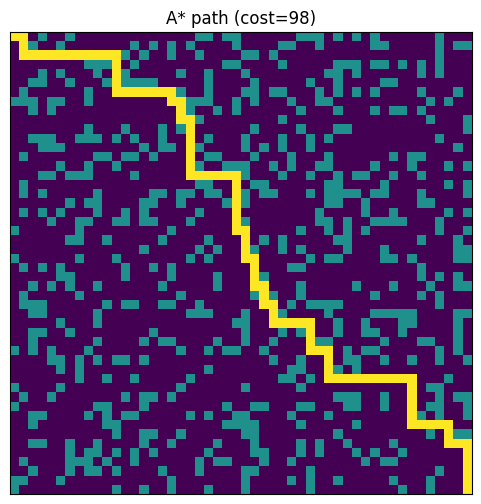

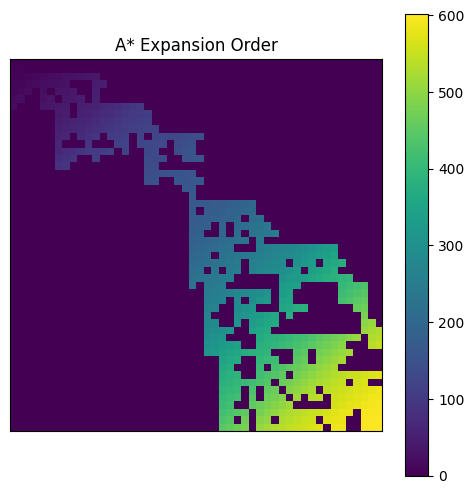

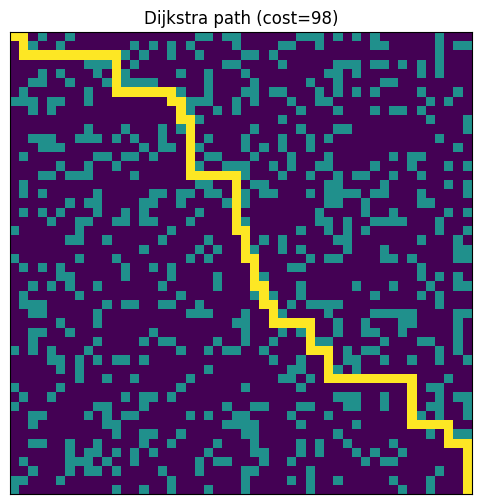

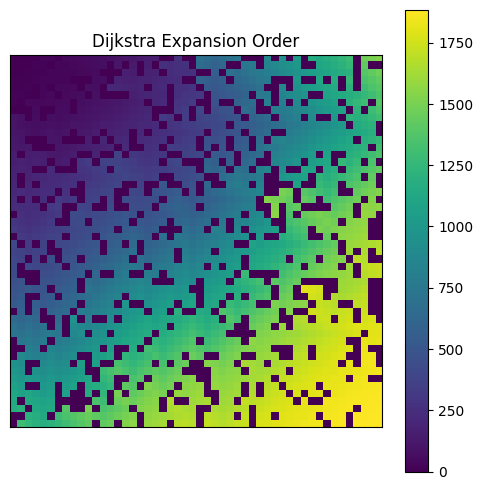

In [5]:
import numpy as np, time, heapq, random
import matplotlib.pyplot as plt
import pandas as pd
random.seed(42); np.random.seed(42)

nrows, ncols, obstacle_prob, seed = 50, 50, 0.25, 7
grid, start, goal = generate_grid(nrows, ncols, obstacle_prob, seed)

# Ensure we have a solvable instance by trying a few seeds if needed
max_tries, tried = 10, 0
result_astar = run_search(grid, start, goal, "astar")
while not result_astar["path"] and tried < max_tries:
    seed += 1; tried += 1
    grid, start, goal = generate_grid(nrows, ncols, obstacle_prob, seed)
    result_astar = run_search(grid, start, goal, "astar")

result_dijkstra = run_search(grid, start, goal, "dijkstra")

print("A*   -> cost:", result_astar["cost"], " expanded:", result_astar["expanded"], " time:", f"{result_astar['runtime']:.4f}s")
print("Dijk -> cost:", result_dijkstra["cost"], " expanded:", f"{result_dijkstra['expanded']:.4f}s", " time:", result_dijkstra['runtime'])

# Visualize
plot_grid_and_path(grid, result_astar["path"], title=f"A* path (cost={result_astar['cost']})")
plot_expansion(result_astar["order"], title="A* Expansion Order")
plot_grid_and_path(grid, result_dijkstra["path"], title=f"Dijkstra path (cost={result_dijkstra['cost']})")
plot_expansion(result_dijkstra["order"], title="Dijkstra Expansion Order")

## Multi-run Comparison (averages across seeds)

In [6]:
import numpy as np, time, heapq, random
import matplotlib.pyplot as plt
import pandas as pd
random.seed(42); np.random.seed(42)

def evaluate_many(nruns=20, nrows=50, ncols=50, obstacle_prob=0.25, seed0=0):
    rows = []
    seed = seed0
    for i in range(nruns):
        grid, start, goal = generate_grid(nrows, ncols, obstacle_prob, seed)
        res_a = run_search(grid, start, goal, "astar")
        res_d = run_search(grid, start, goal, "dijkstra")
        ok = (len(res_a["path"]) > 0) and (len(res_d["path"]) > 0)
        rows.append({
            "seed": seed,
            "success": ok,
            "astar_cost": (res_a["cost"] if res_a["path"] else np.nan),
            "astar_expanded": res_a["expanded"],
            "astar_time": res_a["runtime"],
            "dijk_cost": (res_d["cost"] if res_d["path"] else np.nan),
            "dijk_expanded": res_d["expanded"],
            "dijk_time": res_d["runtime"],
        })
        seed += 1
    return pd.DataFrame(rows)

df = evaluate_many(nruns=20, nrows=50, ncols=50, obstacle_prob=0.25, seed0=0)
display(df.head())
print("\nAverages over successful runs only:")
succ = df[df["success"]==True]
summary = pd.DataFrame({
    "metric": ["cost (steps)", "nodes expanded", "runtime (s)"],
    "A* (mean)": [succ["astar_cost"].mean(), succ["astar_expanded"].mean(), succ["astar_time"].mean()],
    "Dijkstra (mean)": [succ["dijk_cost"].mean(), succ["dijk_expanded"].mean(), succ["dijk_time"].mean()],
})
display(summary)
print(f"Success rate: {succ.shape[0]}/{df.shape[0]} = {succ.shape[0]/max(1,df.shape[0]):.0%}")

,seed,success,astar_cost,astar_expanded,astar_time,dijk_cost,dijk_expanded,dijk_time
0,0,False,NaN,4,0.000083,NaN,4,0.000045
1,1,True,98.0,864,0.010080,98.0,1856,0.022121
2,2,False,NaN,1794,0.025934,NaN,1794,0.015606
3,3,True,100.0,703,0.004905,100.0,1838,0.012656
4,4,False,NaN,1877,0.018066,NaN,1877,0.022337



Averages over successful runs only:


,metric,A* (mean),Dijkstra (mean)
0,cost (steps),98.307692,98.307692
1,nodes expanded,804.769231,1855.461538
2,runtime (s),0.011238,0.026016


Success rate: 13/20 = 65%



## Notes
- With 4-connected unit-cost moves, Manhattan distance is an admissible heuristic, so A* remains optimal.
- Try changing `obstacle_prob`, `nrows/ncols`, and number of runs to see how results vary.
